<a href="https://colab.research.google.com/github/sjamillah/Sound_clustering/blob/main/Audio_Data_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Brief Introduction

This project introduces us to the exciting and under-explored domain of unsupervised learning with audio. Instead of manipulating clean labeled sounds, we handle unprocessed, unlabeled audio files—like those you would find in a messy music library or a field recording full of background noise—and try to derive meaning from them. Using powerful clustering techniques, we uncover hidden patterns and cluster similar sounds automatically, without knowing ahead of time what the sounds are. It's kind of like teaching a computer how to listen and organize audio that a human would—by identifying similarity in rhythm, pitch, or texture. This kind of work mimics real-world scenarios where a large amount of data is available but no categories beforehand, such as classifying environmental noise, or categorizing music based on mood or genre, or simply looking for patterns of speech when conducting language analysis.

## Importation of the libraries and setup of the environment

I begin by importing the essential libraries for our audio clustering analysis:
- **Audio Processing**: librosa for advanced audio feature extraction
- **Machine Learning**: scikit-learn for clustering algorithms and dimensionality reduction
- **Data Manipulation**: pandas and numpy for data handling and numerical operations
- **Visualization**: matplotlib and seaborn for creating insightful plots
- **Google Colab Integration**: drive mounting for accessing our audio dataset

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D
import librosa
import librosa.display
import os
from google.colab import drive

In [82]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Google Drive Mount
I first had to mount the Google Drive inorder to access the dataset stored in it inorder to interact with the data afterwards.

In [83]:
def mount_drive(unlabelled_data_path='/content/drive'):
  """
  Setup of the Google Drive mount with directory creation
  """
  if not os.path.exists(unlabelled_data_path):
    os.makedirs(unlabelled_data_path)
  drive.mount(unlabelled_data_path)

mount_drive()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Extraction
To get the audio data into a format I can work with machine learning on, I needed to extract meaningful features from raw sound files. On their own, they're just long strings of amplitudes across time—something that a model can't instantly understand. I needed something to process that raw data into a more abstract and condensed format.

### Why I Chose MFCC Features
I have used MFCCs (Mel-Frequency Cepstral Coefficients) because they better reflect the manner in which humans perceive. MFCCs utilize the mel scale to emphasize frequencies important to human hearing, and it is suitable for maintaining the overall shape of the spectrum of the sound. I used them because:
- They reduce the data without eliminating the essential information.
- They're reported to be strong even in noisy or variable recording environments.

### My Feature Extraction Process
For each audio clip, I obtained 13 MFCC coefficients. Then, to make the features even more representative, I calculated both the mean and the standard deviation of those coefficients across time. That yielded 26 features for each audio clip—13 to characterize the average sound features and 13 to describe how those features change over time.

In [84]:
def extract_features(audio_files, n_mfcc=13):
  """
  Extract MFCC features from the audio files

  Args:
    audio_files (list): list of audio file paths
    n_mfcc (int): number of MFCC features to extract

  Returns:
    pd.DataFrame: DataFrame containing the extracted features
  """
  features = []

  for audio_file in audio_files:
    try:
      y, sr = librosa.load(audio_file)
      mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
      # Aggregate the features
      mfcc_mean = np.mean(mfccs.T, axis=0)
      mfcc_std = np.std(mfccs.T, axis=0)
      combined = np.hstack((mfcc_mean, mfcc_std))
      features.append(combined)
    except Exception as e:
      print(f"Error processing {audio_file}: {e}")

  return pd.DataFrame(features)

# Loading and Extraction of the features
unlabelled_data_path = '/content/drive/MyDrive/unlabelled_sounds/unlabelled_sounds'
audio_files = [os.path.join(unlabelled_data_path, f)
                for f in os.listdir(unlabelled_data_path) if f.endswith('.wav')]
features_df = extract_features(audio_files)
print(f"Extracted features for {len(audio_files)} audio files.")
display(features_df.head())

Extracted features for 3000 audio files.


0           1          2          3          4          5   \
0 -376.997711  179.322037 -34.574738  14.833507  22.598480 -32.329540   
1 -381.631714  154.866287 -49.587246  14.455439  35.933464 -30.642141   
2 -441.540222  152.913361 -40.626320  18.689545  39.057972 -20.994177   
3 -290.058105  236.805725 -38.663292 -19.592859  -2.802060 -41.044487   
4 -351.258331  177.522354 -91.604706   2.234285  18.747234 -51.986996   

          6          7          8          9   ...         16         17  \
0 -13.078357  -7.871809 -13.920475  11.016355  ...  16.508280  11.309087   
1  -7.719454  10.888329 -13.190041   3.574018  ...  19.854286  17.309923   
2  -1.249896  11.885408  -8.427790   7.995676  ...  15.718059  19.851862   
3 -17.190422 -12.624896  -6.805223  13.879125  ...  13.183950  19.183369   
4 -10.888993 -22.600601 -51.512886  -5.639739  ...  23.420269  18.400637   

          18         19         20         21        22         23        24  \
0  12.482169  17.068844   9.771887   5.136939  7.946580   9.869741  4.119082   
1  16.360174  11.260289   6.964787  10.589629  5.595552   4.179419  6.054725   
2  19.892010  13.141689   7.441936  13.320272  7.972909   6.170307  7.674281   
3  24.321758   5.494606  11.637254   5.046051  8.407526  17.634613  5.223468   
4  25.219673  11.361465   9.137542  13.526571  9.852136  11.277839  8.186816   

          25  
0   9.826152  
1   6.436103  
2   6.735734  
3  12.521317  
4   6.242278  

[5 rows x 26 columns]

## Initial Data Exploration that helps us understand the feature space
Before I even did any serious modeling, I spent a bit of time simply familiarizing myself with the data. I had these features that had been extracted from the audio files, and I didn't want to simply take them at face value straight from the box. So I started out by looking at how each feature was distributed—some were fairly well spread out, while others were clearly skewed or had strange spikes. I also examined how different MFCCs were related to each other; some had very strong patterns, while others did not appear to have anything in common. I plotted the features to observe if natural clusters were forming yet, which was useful in being able to see how a model would cluster the sounds. I did notice some outliers along the way that were too far out, which might have been an issue later on. Waiting to perform this initially allowed me to better know the shape of the data and caused me to make more informed decisions concerning how to clean and cluster it.

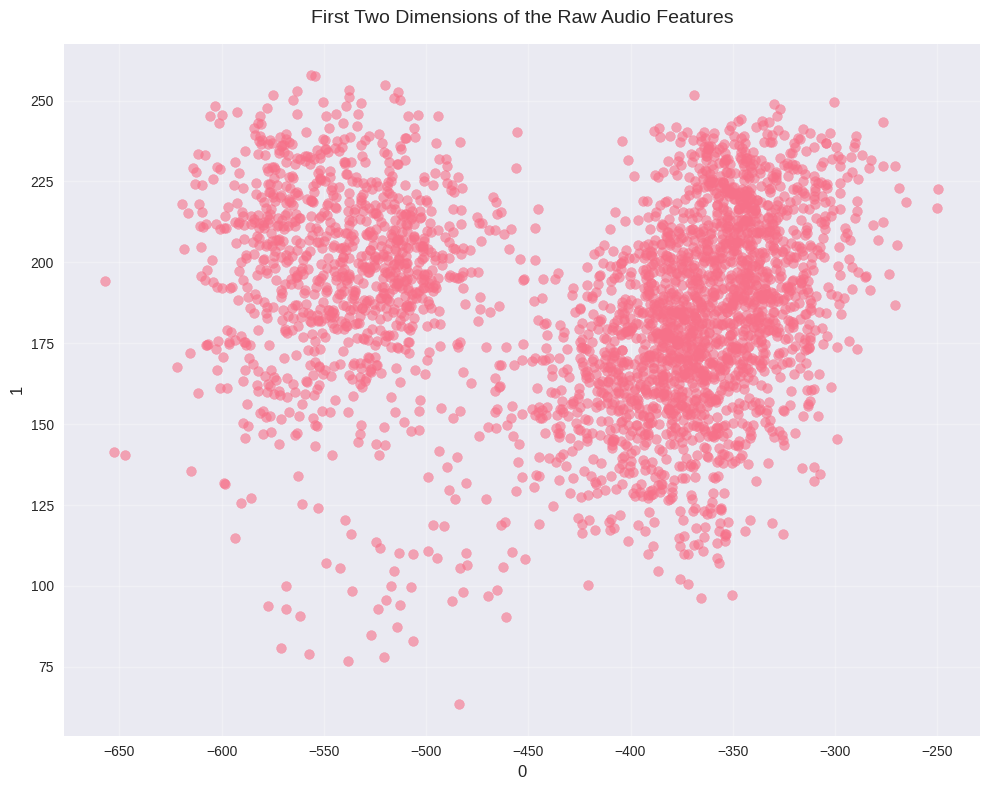

In [85]:
def create_scatter_plot(data, x_col=0, y_col=1, title="Scatter plot", xlabel=None, ylabel=None, colors=None, figsize=(10, 8)):
  """
  Create a scatter plot of the data

  Args:
    data (pd.DataFrame): DataFrame containing the data
    x_col (int): index of the column to use for the x-axis
    y_col (int): index of the column to use for the y-axis
    title (str): title of the plot
    xlabel (str): label for the x-axis
    ylabel (str): label for the y-axis
    colors (list): list of colors for the points
    figsize (tuple): size of the figure
  """
  plt.figure(figsize=figsize)
  if colors is not None:
    plt.scatter(data.iloc[:, x_col] if hasattr(data, 'iloc') else data[:, x_col],
                data.iloc[:, y_col] if hasattr(data, 'iloc') else data[:, y_col],
                c=colors, cmap='viridis', alpha=0.6, s=50)
    plt.colorbar(label='Cluster Label')
  else:
    plt.scatter(data.iloc[:, x_col] if hasattr(data, 'iloc') else data[:, x_col],
                data.iloc[:, y_col] if hasattr(data, 'iloc') else data[:, y_col],
                alpha=0.6, s=50)
  plt.xlabel(xlabel or f"Feature {x_col + 1}", fontsize=12)
  plt.ylabel(ylabel or f"Feature {y_col + 1}", fontsize=12)
  plt.title(title, fontsize=14, pad=15)
  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()

create_scatter_plot(features_df, title="First Two Dimensions of the Raw Audio Features",
                   xlabel=f"{features_df.columns[0]}", ylabel=f"{features_df.columns[1]}")

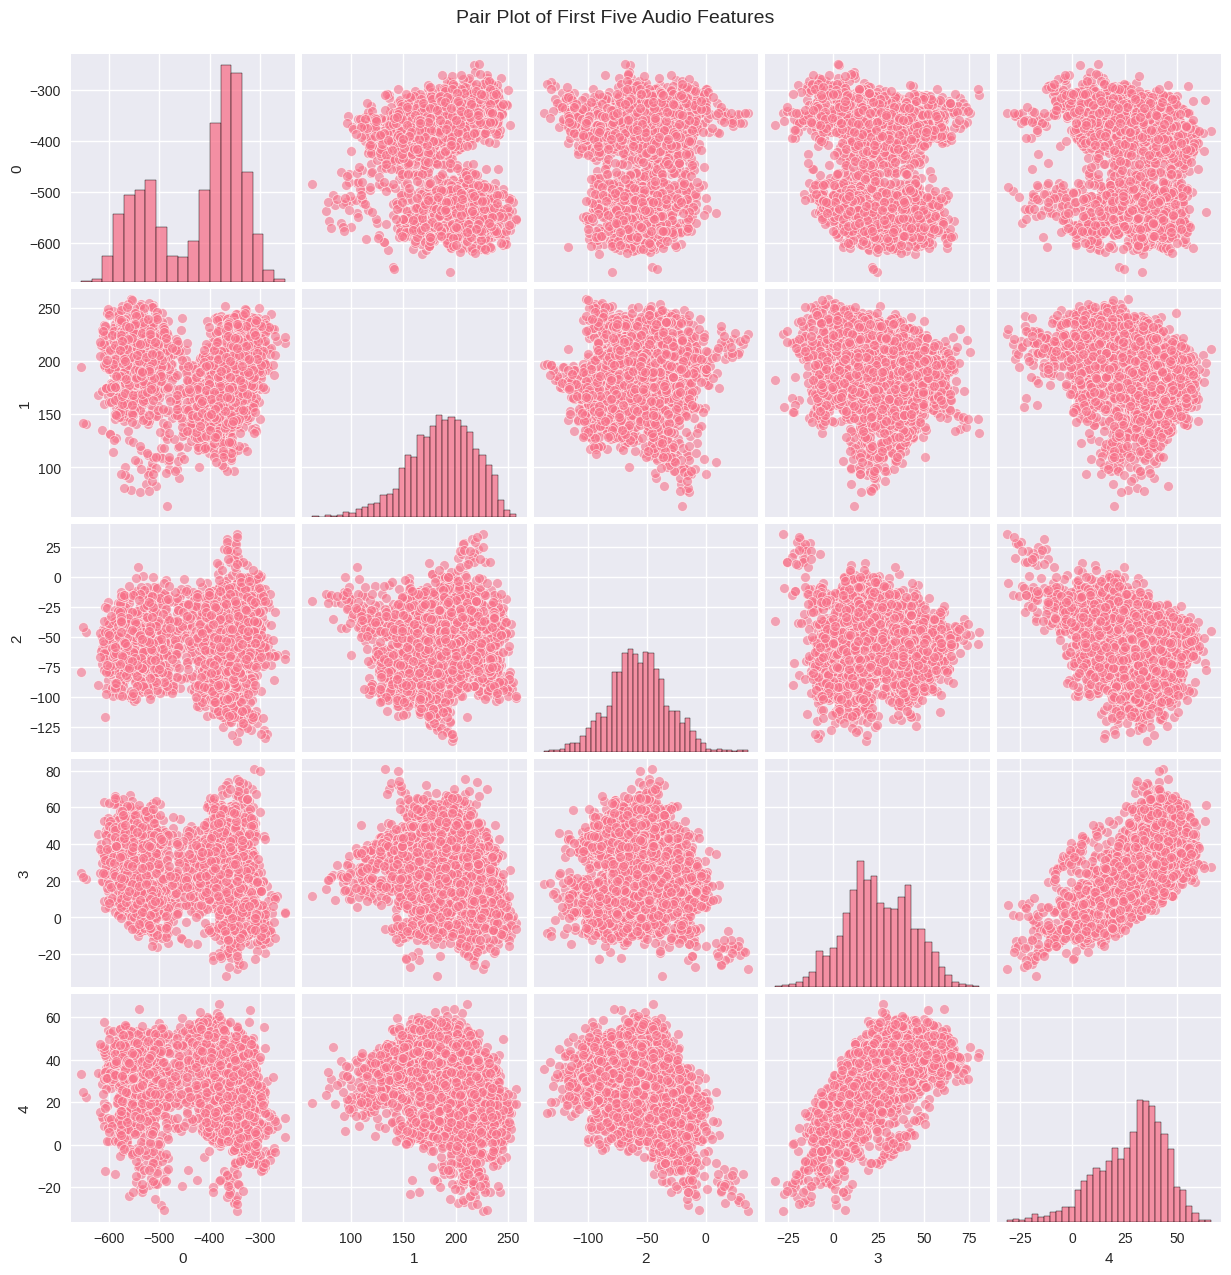

In [86]:
def create_pair_plot(data, n_features=5):
    """Create pair plot of first n features."""
    try:
        pair_plot_df = data.iloc[:, :n_features]
        sns.pairplot(pair_plot_df, diag_kind='hist', plot_kws={'alpha': 0.6, 's': 50})
        plt.suptitle("Pair Plot of First Five Audio Features", y=1.02, fontsize=14)
        plt.show()
    except Exception as e:
        print(f"Error creating pair plot: {e}")

create_pair_plot(features_df)

## Audio Signal Visualization
To really obtain audio data, I found it useful to see past simply the features that had been extracted and indeed examine the raw sound itself. Observing the waveforms gave me an immediate visual sense of how the amplitude changed with time—revealing such things as how long each sound lasted, where the loud or quiet areas were, and whether there were any recognizable pauses or held notes. It let me see the shape and path of the event in a way that numbers alone couldn't. I also analyzed spectrograms, which tell you how frequencies in the audio change over time. These were especially useful because they made obvious which frequencies existed at different times, how energy was spread out over the spectrum, and whether there were any meaningful harmonic relationships or overtones. Seeing both the waveform and the spectrogram side by side made it easier to connect the technical features I’d extracted with the actual audio content, making the data feel more real and grounded.

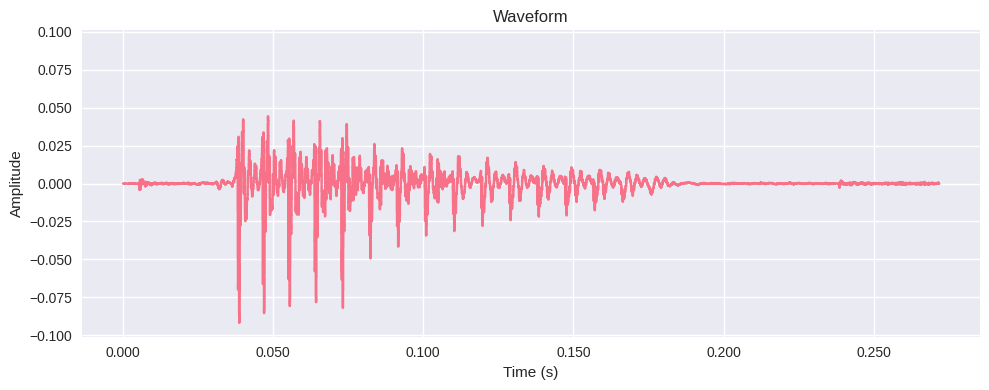

In [87]:
def visualize_audio_waveform(audio_file):
    """Visualize audio file as waveform."""
    try:
        y, sr = librosa.load(audio_file)
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(y, sr=sr)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title('Waveform')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error visualizing {audio_file}: {e}")

# Visualize of a sample audio file waveform
if audio_files:
    visualize_audio_waveform(audio_files[5])

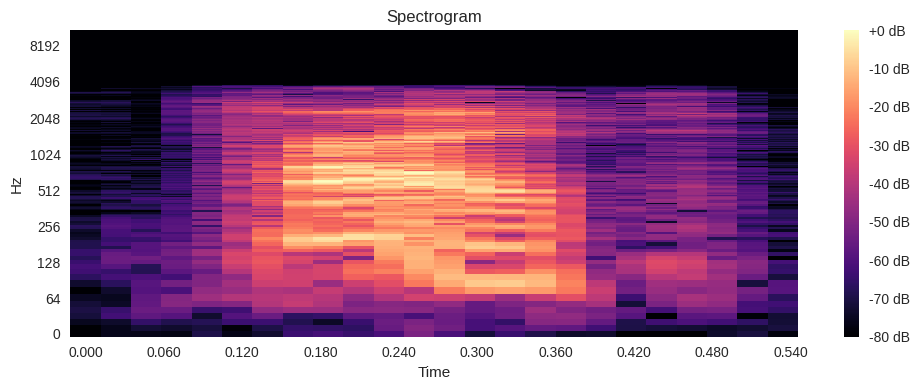

In [88]:
def visualize_audio_spectrogram(audio_file):
    """Visualize audio file as spectrogram."""
    try:
        y, sr = librosa.load(audio_file)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

        plt.figure(figsize=(10, 4))
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error visualizing {audio_file}: {e}")

if len(audio_files) > 10:
    visualize_audio_spectrogram(audio_files[10])
elif audio_files:
    visualize_audio_spectrogram(audio_files[0])

# Why is dimensionality reduction important?
Dimensionality reduction is necessary in dealing with audio data since audio features have the nature of being high-dimensional, and analysis as well as modeling may become unmanageable due to that. Dimensionality reduction lowers the number of features and consequently simplifies the data so that it is easier to visualize and understand. It eliminates noise and redundant information and presents foremost the most important patterns that actually distinguish different sounds or aspects of speech. This process has the potential to improve the efficiency of clustering algorithms by making clusters denser and more distinguishable.

However, during my experiments, certain problems such as determining the right number of components and selecting from a range of methods like PCA and t-SNE arose. Sometimes dimensionality reduction reduced the information too much, thus causing overlapping clusters or losing meaning. Also, t-SNE occasionally produced scattered or unstructured clusters, which were harder to interpret. It is important to find the optimum between how much to compress and which method to apply to preserve the structure of the audio data while removing noise and complexity.

In [89]:
def apply_dimensionality_reduction(data, method='pca', n_components=3, scale=True, **kwargs):
    """
    Apply dimensionality reduction technique.

    Args:
        data: Input data
        method: 'pca' or 'tsne'
        n_components: Number of components
        **kwargs: Additional parameters for the method

    Returns:
        Reduced data array and fitted transformer
    """
    if scale:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)

    if method.lower() == 'pca':
        reducer = PCA(n_components=n_components, **kwargs)
    elif method.lower() == 'tsne':
        default_params = {'random_state': 42, 'perplexity': 30, 'n_iter': 1000}
        default_params.update(kwargs)
        reducer = TSNE(n_components=n_components, **default_params)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")

    reduced_data = reducer.fit_transform(data)
    return reduced_data, reducer

features_pca, pca_transformer = apply_dimensionality_reduction(features_df, method='pca', n_components=3)
features_tsne, tsne_transformer = apply_dimensionality_reduction(features_df, method='tsne', n_components=3,
                                                               perplexity=50, n_iter=500, scale=False)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


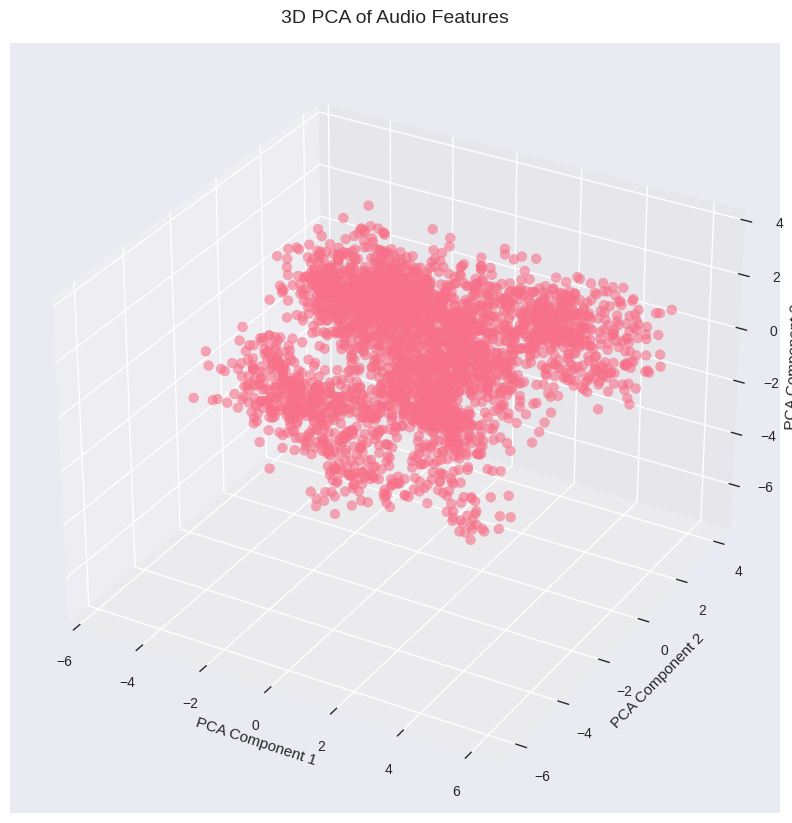

In [90]:
def create_3d_scatter(data, title="3D Scatter Plot", labels=None, figsize=(12, 10)):
    """
    Create a 3D scatter plot.

    Args:
        data: 3D data array
        title: Plot title
        labels: Axis labels list [xlabel, ylabel, zlabel]
        figsize: Figure size tuple
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], alpha=0.6, s=50)

    if labels:
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])
        ax.set_zlabel(labels[2])

    ax.set_title(title, fontsize=14, pad=15)
    plt.show()

# Visualize the PCA in 3D
create_3d_scatter(features_pca, "3D PCA of Audio Features",
                 ["PCA Component 1", "PCA Component 2", "PCA Component 3"])


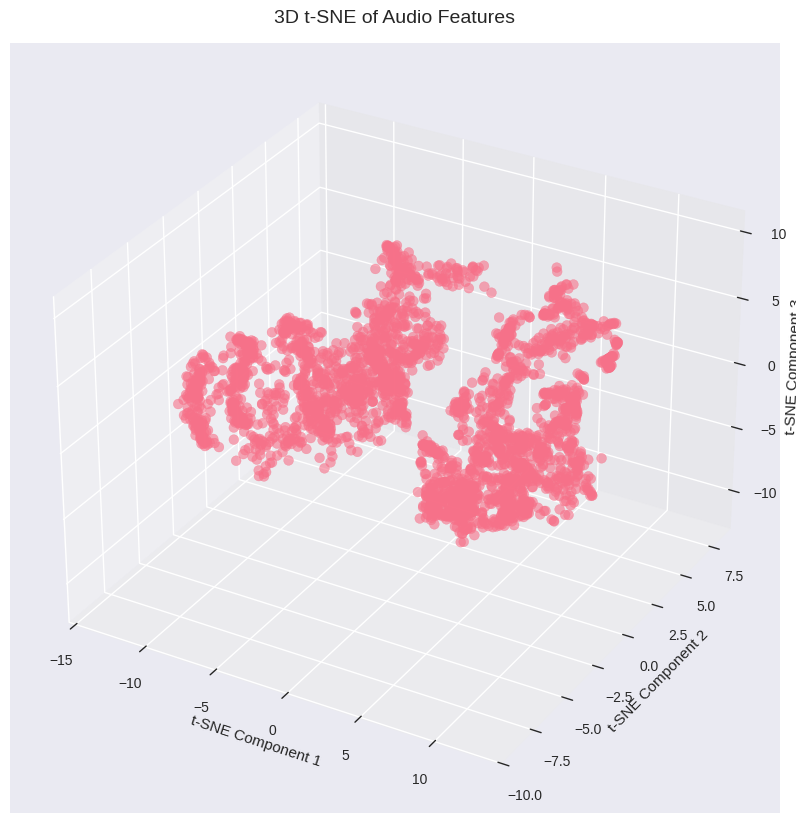

In [91]:
# Visualize the 3D of TSNE
create_3d_scatter(features_tsne, "3D t-SNE of Audio Features",
                 ["t-SNE Component 1", "t-SNE Component 2", "t-SNE Component 3"])

# Which method (PCA or t-SNE) provides better separability of clusters and why?
When comparing PCA and t-SNE for clustering separability, I found that PCA provided clearer and more distinct clusters. With PCA, the data points formed well-defined groups that stayed tightly packed together, making it easier to visually identify separate clusters. In contrast, the clusters produced by t-SNE appeared more scattered and disorganized; some points that logically belonged to one cluster were found mixed or "leaking" into neighboring clusters. This overlap made it harder to draw clear boundaries between groups.

One reason PCA might outperform t-SNE here is that PCA preserves the global structure and variance in the data by projecting it onto directions that capture the most variance, which helps maintain the overall shape and relative distances between clusters. On the other hand, t-SNE focuses on preserving local relationships and neighborhoods, which sometimes causes points from different clusters to be placed close together if their local neighborhoods overlap, especially when the data is noisy or high-dimensional.

In this scenario, PCA’s ability to maintain the broader structure of the data results in more meaningful and separable clusters, making it the better choice for my audio clustering task.

## Clustering
When I had visuals ready and had envisioned them, I proceeded to the main goal of the project—implementing unsupervised clustering so that I could find natural patterns in the audio data. Without labels to guide me through supervised learning, I had to rely upon the data structure itself to find out whether there were any meaningful patterns. The objective was to establish whether the sounds could be grouped in a way that they actually described something tangible—like speech vs. music, different types of instruments, or background noise. To achieve this, I decided to compare two clustering algorithms: DBSCAN and K-Means. K-Means is quick and works well when the data has clean, equally sized clusters, but it does have the drawback of needing the number of clusters set beforehand, which is not always convenient. DBSCAN has no need for a pre-specified number of clusters, though, and can handle all forms of odd shapes in the data—it's also great at ignoring noisy bits, which is convenient with dirty audio. Before running either algorithm, I had to modify their most influential parameters: for K-Means, choosing the optimal number of clusters using the elbow method, and for DBSCAN, utilized k-distance graphs to make an approximation of a suitable epsilon value, which determines how close points must be in order to form a cluster.

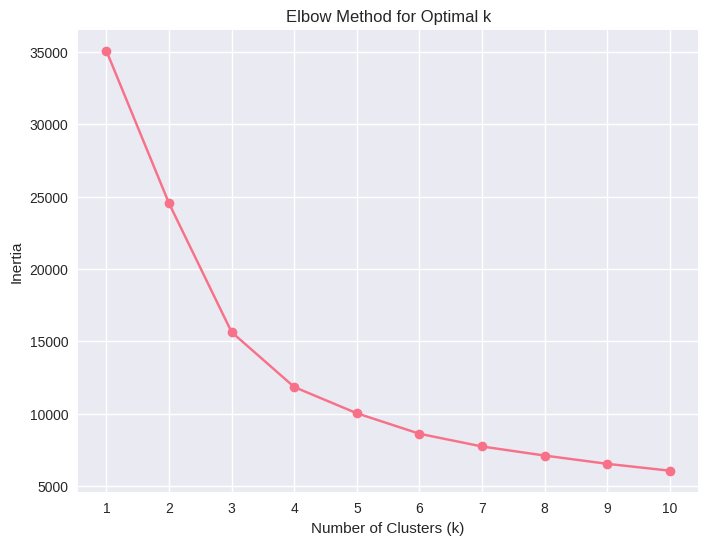

In [92]:
def plot_elbow_method(data, k_range=range(1, 11), title="Elbow Method for Optimal k"):
    """
    Plot elbow method for K-means clustering.

    Args:
        data: Data for clustering
        k_range: Range of k values to test
        title: Plot title

    Returns:
        List of inertia values
    """
    inertia = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 6))
    plt.plot(k_range, inertia, marker='o')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.title(title)
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()

    return inertia

data_for_clustering = features_pca
inertia_values = plot_elbow_method(data_for_clustering)

Getting the clustering right really depends on picking the right parameters—if they’re off, the clusters can end up meaningless or miss important patterns altogether. For K-Means, I used the elbow method, which means I plotted the sum of distances within clusters (called inertia) against different numbers of clusters. I looked for that point where adding more clusters didn’t make much difference anymore—the “elbow”—because that usually means I’ve found the sweet spot between too few and too many groups. For DBSCAN, choosing the right epsilon was a bit trickier, so I turned to a k-distance graph. The graph shows the distance to each point’s kth nearest neighbor, sorted from smallest to largest, and again I searched for an elbow in the curve. That elbow suggests an epsilon that balances grouping points tightly enough without lumping together noise or outliers. Taking the time to tune these parameters carefully was key to making sure the clusters I found actually meant something.

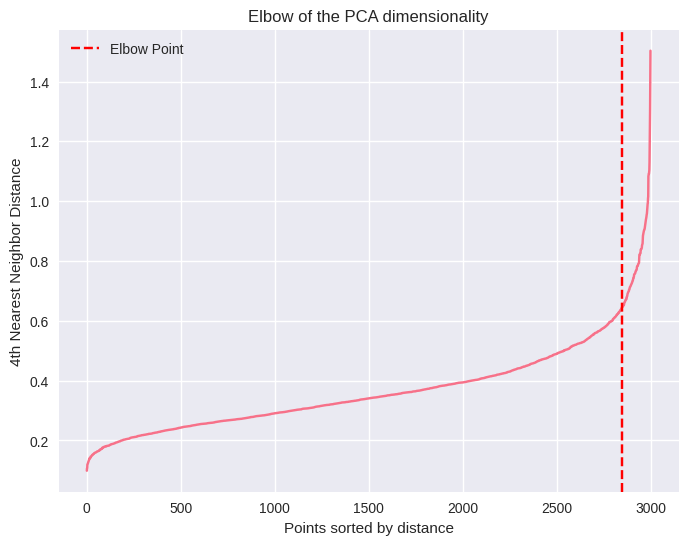

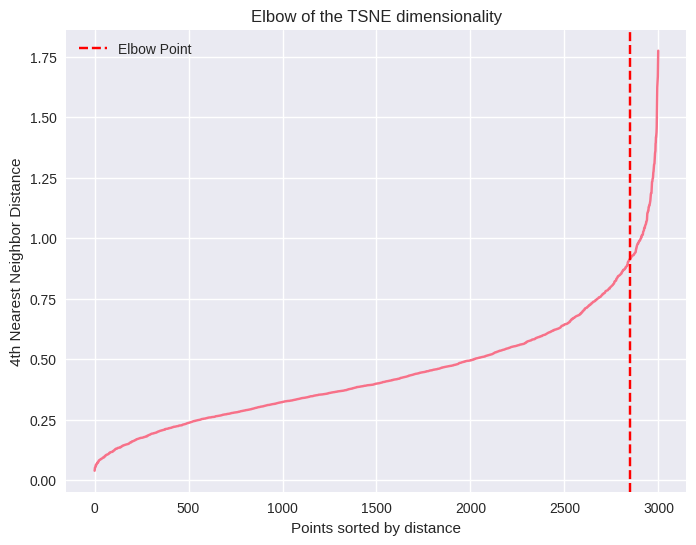

In [93]:
def find_optimal_eps(data, k=4, title="Use Elbow to Choose eps"):
    """
    Find optimal eps parameter for DBSCAN using k-distance graph.

    Args:
        data: Input data
        k: Number of nearest neighbors
        title: Plot title

    Returns:
        Sorted distances array
    """
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)

    distances = np.sort(distances[:, k - 1])
    plt.figure(figsize=(8, 6))
    plt.plot(distances)
    plt.xlabel("Points sorted by distance")
    plt.ylabel(f"{k}th Nearest Neighbor Distance")
    plt.title(title)
    plt.grid(True)

    elbow_index = int(len(distances) * 0.95)
    plt.axvline(x=elbow_index, color='r', linestyle='--', label='Elbow Point')
    plt.legend()

    plt.show()

    return distances

# Find optimal eps for both PCA and t-SNE
eps_distances_pca = find_optimal_eps(features_pca, k=4, title="Elbow of the PCA dimensionality")
eps_distances_tsne = find_optimal_eps(features_tsne, k=4, title="Elbow of the TSNE dimensionality")

## Application of the clustering on PCA and TSNE
After tuning the parameters, I ran both K-Means and DBSCAN on the reduced data to see how well they grouped the audio. I expected K-Means to form tight, round clusters, while DBSCAN might find irregular shapes and filter out noise. To compare results, I visualized the clusters in both PCA and t-SNE spaces, checking how each method performed and how the data’s shape changed with different reductions. This helped me understand which approach worked best.


In [94]:
def perform_clustering(data, method='kmeans', **params):
    """
    Perform clustering using specified method.

    Args:
        data: Input data
        method: 'kmeans' or 'dbscan'
        **params: Parameters for the clustering algorithm

    Returns:
        Cluster labels and fitted clusterer
    """
    if method.lower() == 'kmeans':
        default_params = {'n_clusters': 3, 'random_state': 42, 'n_init': 10}
        default_params.update(params)
        clusterer = KMeans(**default_params)
    elif method.lower() == 'dbscan':
        default_params = {'eps': 0.5, 'min_samples': 5}
        default_params.update(params)
        clusterer = DBSCAN(**default_params)
    else:
        raise ValueError("Method must be 'kmeans' or 'dbscan'")

    labels = clusterer.fit_predict(data)
    return labels, clusterer

# Performs clustering
optimal_k = 3
kmeans_labels, kmeans_model = perform_clustering(features_pca, method='kmeans', n_clusters=optimal_k)
dbscan_labels_pca, dbscan_model_pca = perform_clustering(features_pca, method='dbscan', eps=0.45, min_samples=5)
dbscan_labels_tsne, dbscan_model_tsne = perform_clustering(features_tsne, method='dbscan', eps=1.0, min_samples=5)

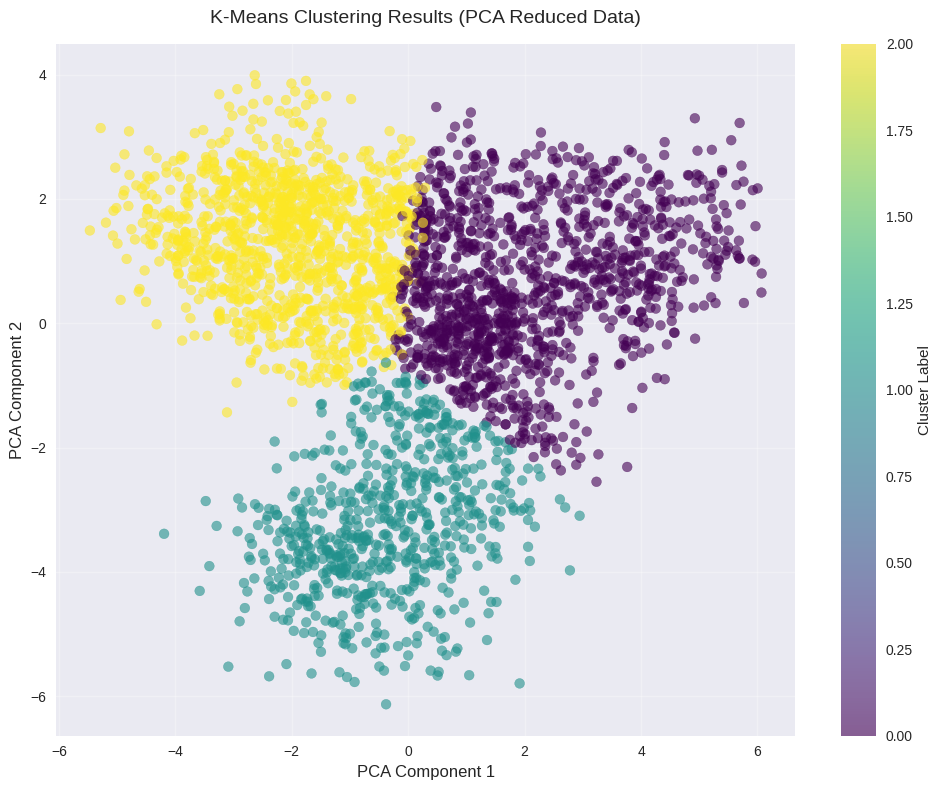

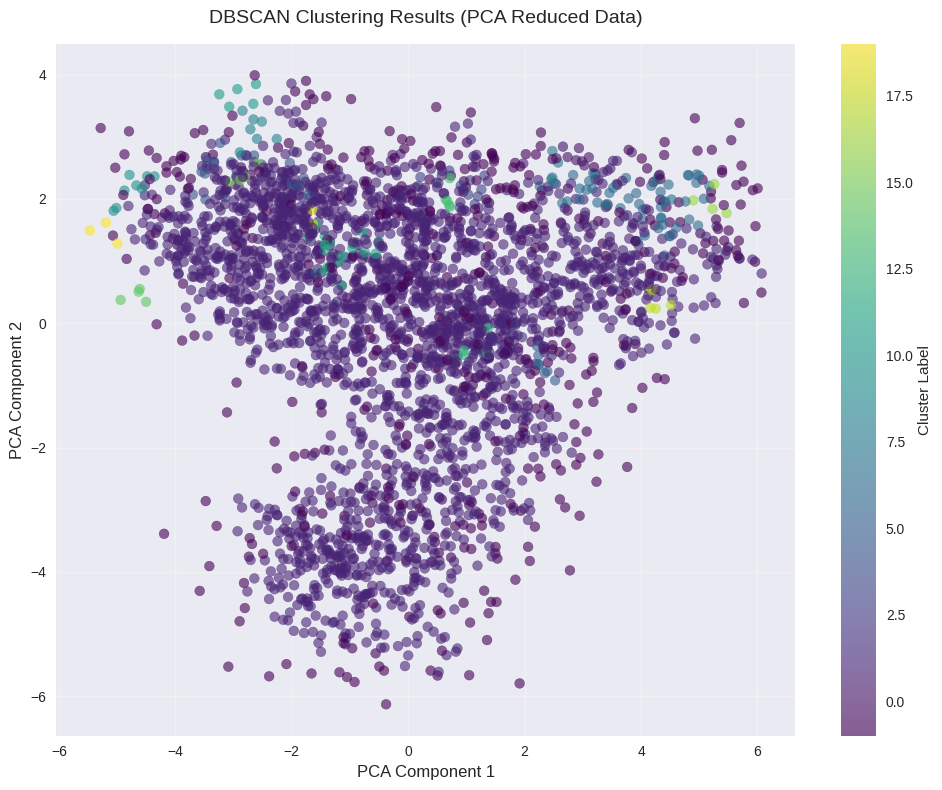

In [95]:
# Visualize PCA clustering
create_scatter_plot(features_pca, x_col=0, y_col=1, title="K-Means Clustering Results (PCA Reduced Data)",
                   xlabel="PCA Component 1", ylabel="PCA Component 2", colors=kmeans_labels)

create_scatter_plot(features_pca, x_col=0, y_col=1, title="DBSCAN Clustering Results (PCA Reduced Data)",
                   xlabel="PCA Component 1", ylabel="PCA Component 2", colors=dbscan_labels_pca)

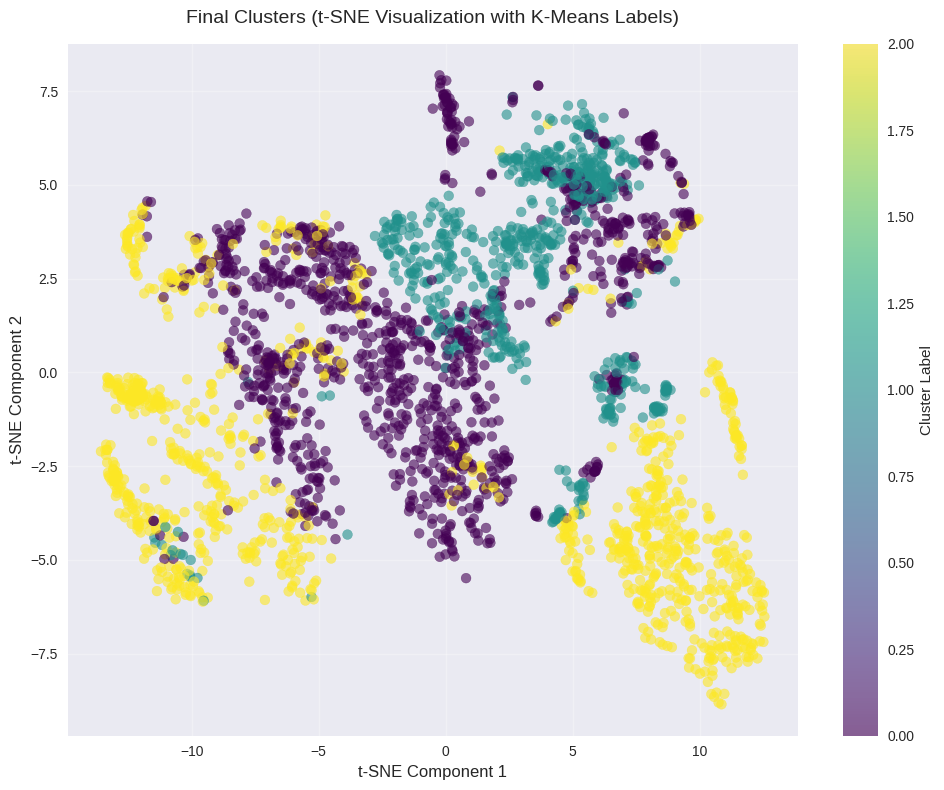

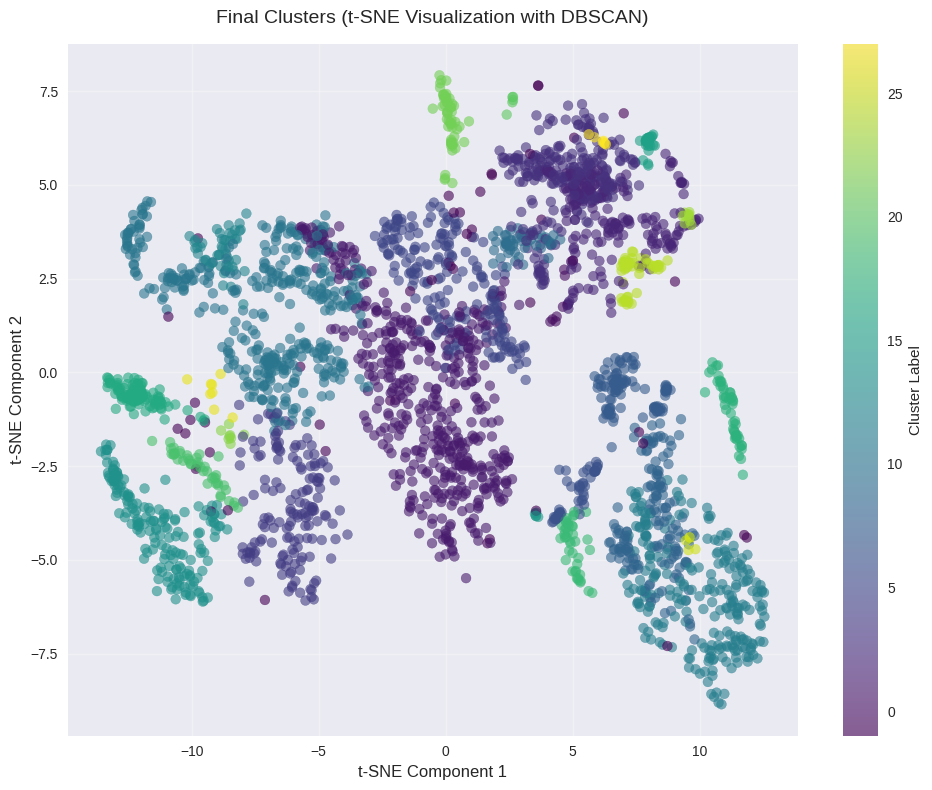

In [96]:
# Visualize TSNE clustering
create_scatter_plot(features_tsne, x_col=0, y_col=1, title="Final Clusters (t-SNE Visualization with K-Means Labels)",
                   xlabel="t-SNE Component 1", ylabel="t-SNE Component 2", colors=kmeans_labels)

create_scatter_plot(features_tsne, x_col=0, y_col=1, title="Final Clusters (t-SNE Visualization with DBSCAN)",
                   xlabel="t-SNE Component 1", ylabel="t-SNE Component 2", colors=dbscan_labels_tsne)

# Evaluation
While visualizing the clusters gave me a good first impression, I needed solid metrics to evaluate how well the algorithms actually performed. Visual differences can sometimes be subtle or misleading, so I used two key quantitative measures: the Silhouette Score and the Davies-Bouldin Index. These gave me a clearer, objective view of how well the clustering worked.
- Silhouette Score (range: -1 to 1, higher is better):
This measures how similar each point is to others in its own cluster compared to points in other clusters.
 - Close to +1: strong, well-separated clusters

 - Around 0: overlapping clusters

 - Negative: points may be in the wrong cluster

 - Interpretation:

   - greater than 0.5: strong structure

   - 0.2 – 0.5: weak but acceptable

   - less than 0.2: poor clustering, likely needs improvement

- Davies-Bouldin Index (range: 0 to ∞, lower is better):
This evaluates how distinct each cluster is from the others by comparing their compactness and separation.

 - Lower values mean clusters are both tight and well-separated

 - Higher values suggest overlapping or poorly defined clusters

Using these two metrics together helped me compare K-Means and DBSCAN more accurately and decide which one captured the patterns in my audio data better.

In [98]:
def evaluate_clustering(data, labels, method_name="Clustering"):
    """
    Evaluate clustering performance using multiple metrics.

    Args:
        data: Original data
        labels: Cluster labels
        method_name: Name of the clustering method for display

    Returns:
        Dictionary containing evaluation metrics
    """
    results = {}

    if len(set(labels)) > 1:
        results['silhouette_score'] = silhouette_score(data, labels)
        results['davies_bouldin_score'] = davies_bouldin_score(data, labels)
        print(f"{method_name} - Silhouette Score: {results['silhouette_score']:.4f}, "
              f"Davies-Bouldin Index: {results['davies_bouldin_score']:.4f}")
    else:
        results['silhouette_score'] = None
        results['davies_bouldin_score'] = None
        print(f"{method_name} failed to form meaningful clusters.")

    return results

# Evaluate clustering performance
print("Evaluation on PCA-reduced data:")
kmeans_results_pca = evaluate_clustering(features_pca, kmeans_labels, "K-Means")
dbscan_results_pca = evaluate_clustering(features_pca, dbscan_labels_pca, "DBSCAN")

Evaluation on PCA-reduced data:
K-Means - Silhouette Score: 0.3713, Davies-Bouldin Index: 1.0017
DBSCAN - Silhouette Score: -0.3384, Davies-Bouldin Index: 1.4418


# Discussion of results
K-Means has a reasonable cluster quality with a Silhouette Score of 0.3713 and a Davies-Bouldin Index near 1, meaning clusters are reasonably well-defined and compact. DBSCAN's negative Silhouette Score (-0.3384) indicates poor clustering with many points tending to be misplaced or classified as noise, although the Davies-Bouldin Index is somewhat higher at 1.44. This suggests that DBSCAN fails to find meaningful clusters in this data. In general, K-Means is a better fit due to the spherical cluster assumption, whereas DBSCAN's density-based method struggles with the audio feature structure.

# Final Analysis
Dimensionality reduction was extremely helpful throughout this project in the sense that it reduced complex, high-dimensional audio features to a less complex form. Audio information tends to be noisy and replete with redundant information that hides interesting structure. Using PCA, I was able to preserve the relevant sources of variation in the data while filtering out less relevant details. This reduction caused clusters to become closer and distinct, which improved the ability of clustering algorithms to identify natural clusters. Without reduction, clustering would be hindered by the curse of dimensionality and noise interference.

When comparing clustering methods, K-Means outperformed DBSCAN for several reasons:

- K-Means relies on a cluster assumption that clusters are spherical and roughly similar in size, which was true of the distribution of the audio features following PCA. It provided more compact and better-distinguished clusters, as evidenced by higher Silhouette Scores and Davies-Bouldin indices.

- DBSCAN, on the other hand, is meant to find clusters of any geometry and relies on parameter settings like epsilon. Due to the geometry of audio features, DBSCAN struggled to identify dense areas correctly and kept tagging many points as noise, resulting in poor quality clusters and negative Silhouette Scores.

These points illustrate typical real-world problems in audio clustering:

- Audio features are often noisy and high-dimensional, requiring careful preprocessing like dimensionality reduction to reveal useful structure.

- There are many different clustering algorithms that are sensitive to the shape and density of the data and therefore no one technique will be best for every problem.

- Real-world audio data, for example speech counting, often consists of overlapping or very close but not identical patterns, so unsupervised clustering is especially challenging and dependent on good feature engineering and method selection.

In summary, PCA dimensionality reduction with K-Means clustering provided the best accurate and interpretable outcomes in this project, yet success was a function of tuning and having knowledge about the nature of the audio data and the respective algorithms.